In [166]:
# 주요 라이브러리 
import copy
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import shutil
from pathlib import Path
throughput_interval = 0.1

In [145]:
# 커널 로그를 기반으로 패킷 송수신 내용 추출
def read(file_name, throughput_analysis=True):
    # 파일 읽기
    with open(file_name) as json_file:
        message = json_file.read()
        
    # 정규식 추출
    # 예시: tcp_header_size,-544,507,48
    # 데이터 이름, Flow id, 시간, 값
    p = re.compile('''([a-z\_0-9]+),([\-0-9]+),([0-9]+),([0-9]+)''')
    result = p.finditer(message)
    
    temp = []
    for r in result:
        key = str(r.group(1))
        flow_id = int(r.group(2))
        flow_time = int(r.group(3))
        value = int(r.group(4))
        temp.append([flow_time, flow_id, key, value])

    # [time, flow_id, key, value] 형태의 테이블 생성
    # 그러나 MPTCP가 아닌 다른 플로우 데이터도 함께 존재함
    table = pd.DataFrame(temp, columns=['time', 'flow_id', 'key', 'value'])
    
    # 가장 많은 데이터를 보낸 3개의 플로우를 제외한 나머지 제거
    table_not_included_meta_flow = table[table['flow_id'] != 0]
    remove_id = table_not_included_meta_flow['flow_id'].value_counts().keys()[2:]
    table = table.loc[table['flow_id'].isin(remove_id) == False]
    
    # 첫 번째 subflow 찾기 (=가장 처음으로 로그가 발생한 플로우)
    temp = table[table['flow_id'] != 0] # MPTCP 레벨이 아닌 것 중
    subflow_id = temp.sort_values(["time"], ascending=[True])
    first_flow = subflow_id.iloc[0]['flow_id']
    
    # 각 flow별로 네임태그 지정
    table.loc[table['flow_id'] == 0, 'flow_id'] = 'mptcp'
    table.loc[table['flow_id'] == first_flow, 'flow_id'] = 'sub1'
    table.loc[(table['flow_id'] != 'mptcp') & (table['flow_id'] != 'sub1') , 'flow_id'] = 'sub2'
    
    # 시간 값 정규화 (커널 시간 -> FLow 시작 시간)
    min_time = table.loc[:,"time"].min() # 기준 값 설정
    
    # 250hz의 세분성
    table.loc[:,"time"] = (table.loc[:,"time"] - min_time) / 250
    
    # total_bytes for mptcp level
    flow = table.loc[(table['key'] == 'mptcp_send') & (table['value'] < 10000)].copy()
    flow['flow_id'] = 'mptcp'
    flow['key'] = 'send'
    
    flow2 = table.loc[(table['key'] == 'mptcp_send')].copy()
    flow2['value'] = flow2['value'].apply(lambda x: x - 10000 if x >= 10000 else x)
    flow2['flow_id'] = 'mptcp'
    flow2['key'] = 'send_included_redundant'
    table = table.loc[table['key'] != 'mptcp_send']
    
    table = pd.concat([table, flow, flow2])
    table.name = file_name
    
    return statistics_table(table)
    # Throughput 및 총 전송량 추가
    total_throughput = []
    
    # range 함수는 int만 지원
    bins = [i / 1000 for i in range(0, 60000, int(throughput_interval * 1000))]

    option = []
    for subflow in ['sub1', 'sub2']:
        flow = select(table, subflow, "send")
        transmission = flow.groupby(pd.cut(flow['time'], bins=bins)).sum()
        y = [i / 1024 / 1024 for i in list(transmission['value'])]

        flow = select(table, subflow, "retransmission")
        retransmission = flow.groupby(pd.cut(flow['time'], bins=bins)).sum()

        sent = 0
        for i in range(0, len(list(transmission['value']))):
            sent += transmission['value'].iloc[i]
            option.append([bins[i], subflow, 'throughput', y[i] / throughput_interval])
            option.append([bins[i], subflow, 'retransmission', retransmission['value'].iloc[i]])
            option.append([bins[i], subflow, 'total_bytes', sent])
    
    # total_bytes for mptcp level
    flow = table.loc[(table['key'] == 'mptcp_send') & (table['value'] >= 10000)].copy()
    flow['value'] -= 10000
    transmission_redundant = flow.groupby(pd.cut(flow['time'], bins=bins)).sum()
    
    flow = table.loc[(table['key'] == 'mptcp_send') & (table['value'] < 10000)]
    transmission_real = flow.groupby(pd.cut(flow['time'], bins=bins)).sum()
    
    sent = 0
    sent_included_redundant = 0
    for i in range(0, len(list(transmission['value']))):
        sent += transmission_real['value'].iloc[i]
        sent_included_redundant += transmission_real['value'].iloc[i]
        sent_included_redundant += transmission_redundant['value'].iloc[i]
        option.append([bins[i], 'mptcp', 'total_bytes', sent])
        option.append([bins[i], 'mptcp', 'total_bytes_included_redundant', sent_included_redundant])
        
    temp = pd.DataFrame(option, columns=['time', 'flow_id', 'key', 'value'])
    table = pd.concat([table, temp])
    table = table.loc[table['key'] != 'mptcp_send']
    table.name = file_name
    return statistics_table(table)

# 정해진 간격으로 통계를 추출
def statistics_table(table):
    bins = [i / 1000 for i in range(0, 60000, int(throughput_interval * 1000))]
    result = {}
    for subflow in table["flow_id"].unique():
        result[subflow] = {}
        table2 = table.loc[table["flow_id"] == subflow]
        for key in table2["key"].unique():
            table3 = table2.loc[table2['key'] == key, ['time', 'value']]
            group = table3.groupby(pd.cut(table3['time'], bins=bins))['value']
            new_table = pd.DataFrame()
            new_table['time'] = bins[0:-1]
            new_table['count'] = list(group.count())
            new_table['min'] = list(group.min())
            new_table['mean'] = list(group.mean())
            new_table['max'] = list(group.max())
            new_table['sum'] = list(group.sum())
            new_table['cumsum'] = new_table['sum'].cumsum()
            new_table['cumcount'] = new_table['count'].cumsum()
            result[subflow][key] = new_table.dropna()
    return result
# 특정 subflow의 데이터를 선택하는 함수
def select(table, subflow, key):
    flow = table.loc[table["flow_id"] == subflow]
    flow = flow.loc[flow['key'] == key]
    return flow

In [169]:
red = read("logs\\그림 5\\redundant0.016 5MBps.txt")

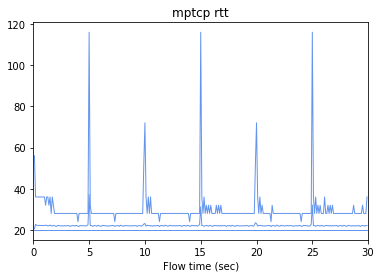

In [174]:
def view(table, flow_id, key, method, time_s = 0, time_e = 30, color=0, label=None, linestyle='-', marker=None, linewidth=1, linetype='a', ylabel=None, func=lambda x: x):
    if (label == None): label = flow_id
    flow = table[flow_id][key]
    flow = flow.loc[(flow['time'] > time_s) & (flow['time'] < time_e)]
    x = flow['time']
    y = flow[method].apply(func)

    nx = []
    ny = []
    for i in range(0,len(x)):
        nx.append(x.iloc[i])
        ny.append(y.iloc[i])
        
    colors = [['cornflowerblue', 'blue'],
             ['sandybrown', 'coral'],
             ['orchid', 'magenta'],
             ['limegreen', 'forestgreen']]
    if linetype == 'scatter':
        plt.scatter(nx,ny, s=0.05, zorder=10, color=colors[color][1])
    else:
        plt.plot(nx, ny, linestyle, linewidth=linewidth,zorder=0, color=colors[color][0], label=label, marker=marker, markersize=2)
    plt.xlabel("Flow time (sec)")
    if (ylabel == None):
        plt.ylabel("")
    else:
        plt.ylabel(ylabel)
    plt.xlim(time_s, time_e)
    #plt.ylim(0,500)
    plt.title(flow_id + " " + key)
# view(red, "mptcp", "send_included_redundant", "sum", func=lambda x: x / 1024 / 1024 / throughput_interval)
# view(red, "mptcp", "send", "sum", func=lambda x: x / 1024 / 1024 / throughput_interval)
view(red, "mptcp", "rtt", "min")
view(red, "mptcp", "rtt", "mean")
view(red, "mptcp", "rtt", "max")

In [175]:
logs = {}
for filename in Path('logs').rglob('*.txt'):
    log_name = os.path.splitext(os.path.basename(filename))[0]
    logs[str(filename)] = read(filename)

In [181]:
def save(table, path):
    filename = path
    base_path = os.path.splitext(filename)[0]
    if os.path.isdir(base_path):
        shutil.rmtree(base_path)
        
    os.mkdir(base_path)
    for subflow in table:
        for key in table[subflow]:
            table[subflow][key].to_csv(base_path + "/" + subflow + "_" + key + ".csv", index=False)

In [182]:
for i in logs:
    print(i)
    save(logs[i], i)

logs\그림 3\default.txt
logs\그림 4\redundant.txt
logs\그림 5\redundant0.008 5MBps.txt
logs\그림 5\redundant0.016 5MBps.txt
logs\전체 실험\1. RTT 강제 변경\1MB 1초\RTT강제변경_blest.txt
logs\전체 실험\1. RTT 강제 변경\1MB 1초\RTT강제변경_default.txt
logs\전체 실험\1. RTT 강제 변경\1MB 1초\RTT강제변경_only_fast.txt
logs\전체 실험\1. RTT 강제 변경\1MB 1초\RTT강제변경_redundant.txt
logs\전체 실험\1. RTT 강제 변경\대역폭 제한 없음\RTT강제변경_blest.txt
logs\전체 실험\1. RTT 강제 변경\대역폭 제한 없음\RTT강제변경_default.txt
logs\전체 실험\1. RTT 강제 변경\대역폭 제한 없음\RTT강제변경_only_fast.txt
logs\전체 실험\1. RTT 강제 변경\대역폭 제한 없음\RTT강제변경_redundant.txt
logs\전체 실험\1. RTT 강제 변경\클라우드\RTT강제변경_blest.txt
logs\전체 실험\1. RTT 강제 변경\클라우드\RTT강제변경_default.txt
logs\전체 실험\1. RTT 강제 변경\클라우드\RTT강제변경_only_fast.txt
logs\전체 실험\1. RTT 강제 변경\클라우드\RTT강제변경_redundant.txt
logs\전체 실험\2. 트래픽이 발생함\1MB 1초\트래픽_blest.txt
logs\전체 실험\2. 트래픽이 발생함\1MB 1초\트래픽_default.txt
logs\전체 실험\2. 트래픽이 발생함\1MB 1초\트래픽_only_fast.txt
logs\전체 실험\2. 트래픽이 발생함\1MB 1초\트래픽_redundant.txt
logs\전체 실험\2. 트래픽이 발생함\대역폭 제한 없음\트래픽_blest.txt
logs\전체 실험\2. 트래픽이 발생함\대역폭 제한